In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print('Done')
'''
# Any results you write to the current directory are saved as output.

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\nprint('Done')\n"

Importing all necessary libraries

In [3]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


**Content:-**

Overall:-
    202,599 number of face images of various celebrities 10,177 unique identities, but names of identities are not given 40 binary attribute       annotations per image 5 landmark locations
    
Data Files:-
* img_align_celeba.zip:- All the face images, cropped and aligned
* list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
* list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
* list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
* list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative
    

1. Data Exploration

a. Image folder.

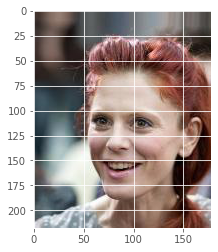

In [4]:
main_folder = '../input/celeba-dataset/'
image_folder = main_folder +'img_align_celeba/img_align_celeba/'
a = image_folder + '000002.jpg'
training = 10000
cross_validation = 2000
test = 2000
img = load_img(a)
plt.imshow(img)


Attributes of all images.

In [5]:
attr = pd.read_csv(main_folder+'list_attr_celeba.csv')
attr.set_index('image_id', inplace = True)
attr.replace(to_replace = -1, value = 0, inplace = True)
for i,j in enumerate(attr.columns):
    print(i,j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


A plot showing Male vs Female

Text(0.5, 1.0, 'Male or Female')

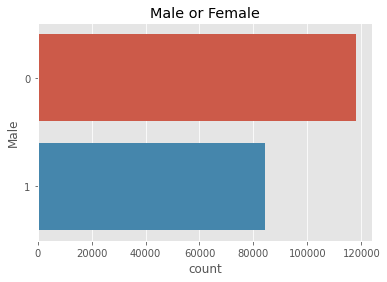

In [6]:
sns.countplot(y = 'Male' , data = attr)
plt.title('Male or Female')

2. Split the database into Training, Validation, Test.

In [7]:
partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


As mentioned earlier, we'll use only use 10,000 images for training, and 2000 each for testing  and cross-validation.

looking for values of testing, train, validation originally allocated.

In [8]:
partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

Now we join the partition sheet with another column 'Male'

In [9]:
partition.set_index('image_id', inplace= True)
par_attr = partition.join(attr['Male'], how='inner')
par_attr.shape

(202599, 2)

2.a) Generate the partitions


In [10]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

Code to generate partitions.

In [11]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [12]:
def generate(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df1 = par_attr[(par_attr['partition'] == partition) 
                           & (par_attr[attr] == 0)].sample(int(num_samples/2))
    df2 = par_attr[(par_attr['partition'] == partition) & (par_attr[attr] == 1)].sample(int(num_samples/2))
    df = pd.concat([df1,df2])

    # for Train and Validation
    if partition != 2:
        x = np.array([load_reshape_img(image_folder + fname) for fname in df.index])
        x = x.reshape((x.shape[0], 218, 178, 3))
        y = np_utils.to_categorical(df[attr],2)
    # for Test
    else:
        x = []
        y = []

        for index, target in df.iterrows():
            im = cv2.imread(image_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x.append(im)
            y.append(target[attr])

    return x, y

**3) Pre-processing images******

3.a) Data Augumentation:

In [13]:
img = load_img(a)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)
type(a)

str

In [14]:
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)



In [15]:
img = load_img(a)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)




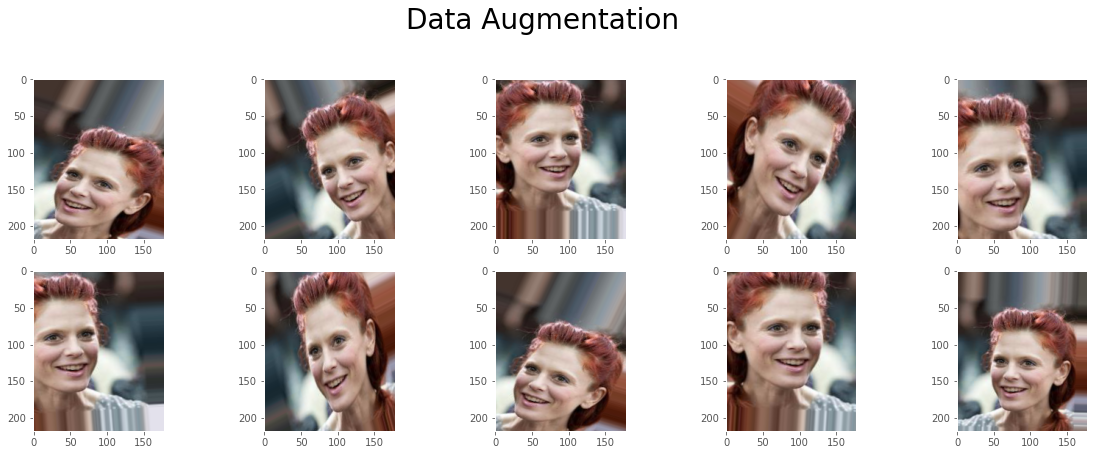

In [16]:
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

3.2) Build Data Generators

First we generate the training data.


In [17]:
X_train, y_train = generate(0, 'Male',training)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,)

train_datagen.fit(X_train)

train_generator = train_datagen.flow(X_train, y_train, batch_size = 16)

Now, for the validation dataset.

In [37]:
X_val, y_val = generate(1, 'Male', cross_validation)


Lastly, for the test dataset

In [19]:
X_test, y_test = generate(2, 'Male', test)


4. Building Model

Downloading the weights from the models.

In [47]:
inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = ((218, 178, 3)))

In [48]:
print('number of layers', len(inception.layers))

number of layers 311


Creating the new final layer of mode.

In [51]:
from keras.layers import GlobalMaxPooling2D

In [52]:
output = inception.output
output = GlobalMaxPooling2D()(output)
output = Dense(1024, activation = 'relu')(output)
output = Dropout(0.5)(output)
output = Dense(512, activation = 'relu')(output)
prediction = Dense(2, activation = 'softmax')(output)

In [53]:
from keras.optimizers import Adam

In [54]:
model = Model(input = inception.input, output = prediction)
for layer in model.layers[:52]:
    layer.trainable = False

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


**Training Model.**

In [55]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [57]:
checkpointer

In [58]:
hist = model.fit_generator(train_generator
                     , validation_data = (X_val, y_val)
                      , steps_per_epoch= training/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20
625/625 [==============================] - 128s 205ms/step - loss: 0.1068 - accuracy: 0.9600 - val_loss: 0.2114 - val_accuracy: 0.9235

Epoch 00001: val_loss did not improve from 0.16856
Epoch 2/20
625/625 [==============================] - 127s 203ms/step - loss: 0.0986 - accuracy: 0.9629 - val_loss: 0.1660 - val_accuracy: 0.9435

Epoch 00002: val_loss improved from 0.16856 to 0.16597, saving model to weights.best.inc.male.hdf5
Epoch 3/20
625/625 [==============================] - 127s 202ms/step - loss: 0.0932 - accuracy: 0.9640 - val_loss: 0.1783 - val_accuracy: 0.9395

Epoch 00003: val_loss did not improve from 0.16597
Epoch 4/20
625/625 [==============================] - 126s 202ms/step - loss: 0.0853 - accuracy: 0.9687 - val_loss: 0.1706 - val_accuracy: 0.9460

Epoch 00004: val_loss did not improve from 0.16597
Epoch 5/20
625/625 [==============================] - 127s 203ms/step - loss: 0.0854 - accuracy: 0.9701 - val_loss: 0.1991 - val_accuracy: 0.9335

Epoch 00005: 

Plot the loss functions of both training and the validation

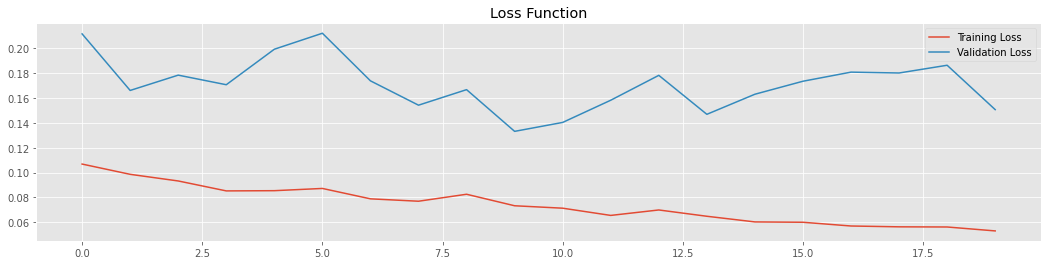

In [62]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Loss Function')
plt.show()

Plot the accuracy of the training and the validaiton 

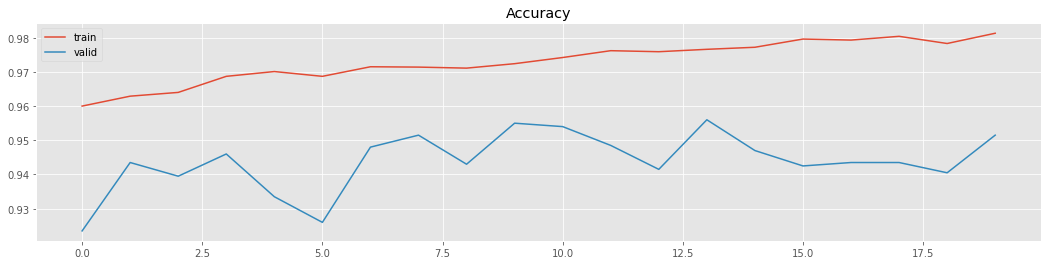

In [65]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

Now to predict on the test data.

In [66]:
model_prediction = [np.argmax(model.predict(features)) for features in X_test]

test_accuracy = 100* np.sum(np.array(model_prediction) == y_test)/len(model_prediction)

print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)


Model Evaluation
Test accuracy: 93.2500%


NameError: name 'model_predictions' is not defined

In [ ]:
print('f1_score:', f1_score(y_test, model_prediction))